In [1]:
import pyEDITH as pE
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# # # set your environment variables:
# os.environ["YIP_CORO_DIR"] = "/Users/mhcurrie/science/packages/yippy/yips/"
# os.environ["SCI_ENG_DIR"] = "/Users/mhcurrie/science/packages/Sci-Eng-Interface/hwo_sci_eng/"

# or you can put these in your .zshrc as 
#export SCI_ENG_DIR=/Users/mhcurrie/science/packages/Sci-Eng-Interface/hwo_sci_eng
#export YIP_CORO_DIR=/Users/mhcurrie/science/packages/yippy/yips/

# Testing pyEDITH spectroscopy mode

### Inputs

Set up a parameters dictionary.

In [2]:
# this is where all the input parameters are stored for EDITH
parameters = {}
parameters["observing_mode"] = "IFS" # tells ETC to use spectroscopy (IFS) mode


Set up the observation object. Eventually, this is where the exposure time or SNR will be placed after calculation. 

In [3]:
# to set up the observation object, we need to specify a few overarching parameters:
parameters["wavelength"] = np.linspace(0.2, 1.8, 1000) # define a wavelength grid in microns
parameters["nlambd"] = len(parameters["wavelength"]) # number of wavelengths
parameters["snr"] = 7*np.ones_like(parameters["wavelength"]) # the SNR you want for each spectral bin 
parameters["CRb_multiplier"] = 2. # factor to multiply the background by (used for differential imaging)
#parameters["photometric_aperture_radius"] = None#0.85 # radius of the photometric aperture in units of lambda/D
parameters["psf_trunc_ratio"] = 0.3 # truncate the off-axis PSFs at this level 

# To get a more realistic wavelength grid, we can tell the ETC to regrid our user-supplied wavelength grid and spectra onto a new wavelength grid
# this is optional. If you don't want to re-grid, then set parameters["regrid_wavelength"] = False
parameters["regrid_wavelength"] = True # set the flag to do this. We also need to specify a few other parameters.
parameters["spectral_resolution"] = np.array([7, 140, 40]) #np.array([140])  # we're going to define three spectral channels. These are the spectral resolutions for each channel. i.e. all spectral bins in a given channel will have a fixed resolution.
parameters['lam_low'] = [0.3, 0.4, 1.] # the lower wavelength bounds for each spectral channel
parameters['lam_high'] = [0.4, 1., 1.7] # the upper wavelength bounds for each spectral channel


#NOTE: there are more parameters we can define (see below), but these are the basics for now.


observation = pE.Observation() # define the observation object
observation.load_configuration(parameters) # load the specified configuration in the parameters dict 
observation.set_output_arrays()
observation.validate_configuration()

print(f"All params in Observation():")
for key in observation.__dict__.keys():
    print("-->", key)


Calculating a new wavelength grid and re-gridding spectra...
All params in Observation():
--> td_limit
--> wavelength
--> delta_wavelength
--> SNR
--> photometric_aperture_radius
--> psf_trunc_ratio
--> CRb_multiplier
--> nlambd
--> tp
--> exptime
--> fullsnr


Let's visualize the spectral channels.

Text(0.5, 0, 'Wavelength [um]')

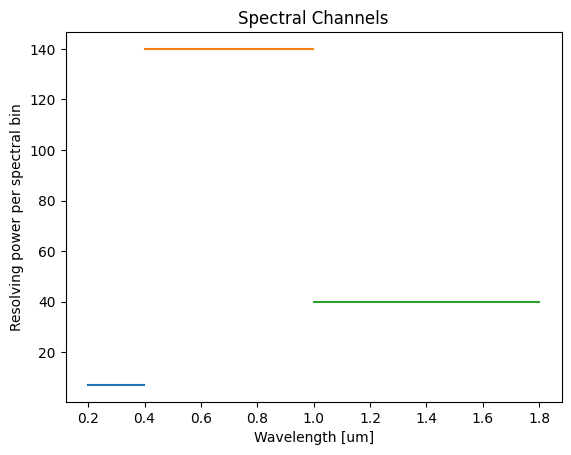

In [ ]:
plt.figure()
plt.title("Spectral Channels")
inds_UV = parameters["wavelength"] < parameters["lam_high"][0]
inds_VIS = (parameters["wavelength"] >= parameters["lam_high"][0]) & (parameters["wavelength"] < parameters["lam_high"][1])
inds_NIR =  parameters["wavelength"] >= parameters["lam_high"][1]
plt.plot(parameters["wavelength"][inds_UV], parameters["spectral_resolution"][0]*np.ones_like(parameters["wavelength"][inds_UV]))
plt.plot(parameters["wavelength"][inds_VIS], parameters["spectral_resolution"][1]*np.ones_like(parameters["wavelength"][inds_VIS]))
plt.plot(parameters["wavelength"][inds_NIR], parameters["spectral_resolution"][2]*np.ones_like(parameters["wavelength"][inds_NIR]))
plt.ylabel("Resolving power per spectral bin")
plt.xlabel("Wavelength [um]")

Set up the astrophysical scene.

First let's do something dumb and model the star/planet as blackbodies for testing.

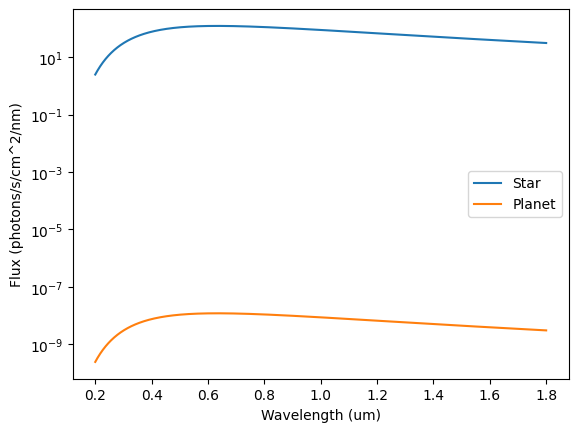

In [5]:
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot import units as synphot_u
import astropy.units as u 
import astropy.constants as c 

def compute_blackbody_photon_flux(temp, wavelengths):
    """Generate photon flux density (photon/s/cm^2/um) for a blackbody at 1 cm^2."""
    bb = SourceSpectrum(BlackBodyNorm1D, temperature=temp)
    

    flux_photlam = bb(wavelengths)#.value * 1/(u.s * u.cm**2 * u.AA) # photons/s/cm2/A
    #flux_photlam = flux_photlam.to(1 / (u.s * u.cm**2 * u.nm)) # convert to 1/nm
    return flux_photlam

def compute_star_flux_observed(stellar_flux_surface, R_star, dist):
    """Scale stellar surface flux to observer distance."""
    scale = (R_star / dist)**2
    return stellar_flux_surface * scale.decompose()


# temp and distance to star
Tstar = 5800 * u.K
dist = 10 * u.pc

# calculate the observed Fs_over_F0 
Fstar = compute_blackbody_photon_flux(Tstar, parameters["wavelength"]*u.um)
Fstar = Fstar.to(u.photon / (u.s * u.cm**2 * u.nm)) # convert to pyEdith units
Fstar_obs_10pc = Fstar * (1000*u.pc/dist)**2 # this gives the flux at 1 kpc. Scale to the distance of the star
contrast = 1e-10 
Fplan_obs = Fstar_obs_10pc*contrast
FpFs = (Fplan_obs / Fstar_obs_10pc).value
plt.figure()
plt.plot(parameters["wavelength"]*u.um, Fstar_obs_10pc, label="Star")
plt.plot(parameters["wavelength"]*u.um, Fplan_obs, label="Planet")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (photons/s/cm^2/nm)")
plt.yscale("log")
plt.legend()

Alternatively, we can load a more realistic Earth reflectance spectrum:

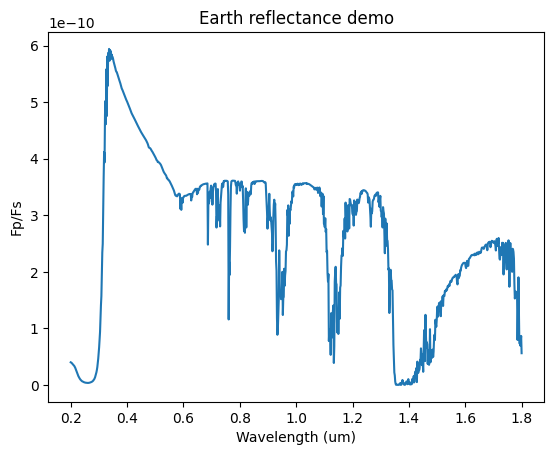

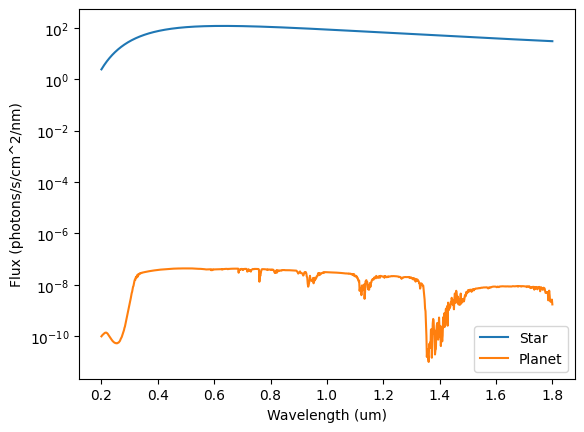

In [6]:
earth_wl, earth_refl = np.loadtxt("../inputs/earth_refl_demo.txt", delimiter=",").T
from scipy.interpolate import interp1d
earth_interp_func = interp1d(earth_wl, earth_refl)
FpFs = earth_interp_func(parameters["wavelength"])
Fplan_obs = Fstar_obs_10pc * FpFs

plt.figure()
plt.plot(parameters["wavelength"]*u.um, FpFs)
plt.xlabel("Wavelength (um)")
plt.ylabel("Fp/Fs")
plt.title("Earth reflectance demo")

plt.figure()
plt.plot(parameters["wavelength"]*u.um, Fstar_obs_10pc, label="Star")
plt.plot(parameters["wavelength"]*u.um, Fplan_obs, label="Planet")
plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (photons/s/cm^2/nm)")
plt.yscale("log")
plt.legend()


We need several more parameters to define the astrophysical scene. These include parameters related to the star, planet, zodi/exozodi...

As an example, lets take the star HD 102365. It is a sun-like star (spectral type G2V) ~10 pc away. 
t is also a Tier A target star from the NASA ExEP HWO target star list. 


In [ ]:
# 
# STAR
parameters["distance"] = 10. # distance to the system in pc
parameters["stellar_radius"] = 1. # radius of the star in solar radii
parameters["Fstar_10pc"] = Fstar_obs_10pc.value # Fstar modeled as a blackbody (see above)

# PLANET
parameters["separation"] = 0.1 # planetary separation in arcsec
parameters["Fp/Fs"] = FpFs # 1e-8 for testing (bright planet)

# SCENE
parameters["nzodis"] = 1. # number of zodis for exozodi estimate
parameters["noisefloor_PPF"] = 30#1. # post-processing factor for stellar speckle subtraction
parameters["ra"] = 176.6292 # approximate ra of HD 102365. WARNING: do not use this number for science. 
parameters["dec"] = -40.5003 # approximate dec of HD 102365. WARNING: do not use this number for science. 
parameters["ez_PPF"] = np.inf # perfect exozodi subtraction 


# ALTERNATIVE WAY OF SETTING PARAMS (in mags)
# parameters["magV"] = 5.84
# parameters["mag"] = 6.189576 * np.ones_like(parameters["wavelength"]) # assume a flat spectrum for now 
# parameters["delta_mag"] = 20 * np.ones_like(parameters["wavelength"]) # originally 25.5 assume a flat spectrum for now


scene = pE.AstrophysicalScene()
scene.load_configuration(parameters)
scene.calculate_zodi_exozodi(parameters)
scene.validate_configuration()

#### IMPORTANT!!! 
#### If you chose to let the ETC re-grid your input spectra (using user supplied settings shown above, then you have to run this extra step.)
if parameters["regrid_wavelength"] is True:
    scene.regrid_spectra(parameters, observation)
    
print("Parameters that the scene object carries:")
for key in scene.__dict__.keys():
    print("-->", key)

Re-gridding spectra onto ETC wavelength grid...
Parameters that the scene object carries:
--> F0V
--> Lstar
--> dist
--> F0
--> min_deltamag
--> Fp_min_over_Fs
--> Fp_over_Fs
--> Fs_over_F0
--> vmag
--> mag
--> deltamag
--> stellar_angular_diameter_arcsec
--> nzodis
--> ra
--> dec
--> separation
--> xp
--> yp
--> ez_PPF
--> M_V
--> Fzodi_list
--> Fexozodi_list
--> Fbinary_list


Set up the observatory: telescope, coronagraph, detector.

Create and configure Observatory using ObservatoryBuilder.
This compiles the telescope, coronagraph, and detector and places them all in a single object. 
These parameters mostly come from the EAC YAML files, but we have to specify a few:


In [ ]:

parameters["observatory_preset"] = "EAC1" # tells ETC to use EAC1 yaml files throughputs
parameters["IFS_eff"]  = 1. # extra throughput of the IFS 
parameters["npix_multiplier"] = np.ones_like(parameters["wavelength"]) # number of detector pixels per spectral bin
parameters["noisefloor_PPF"] = 30 # post processing factor of 30 is a good realistic value for this

observatory_config = pE.parse_input.get_observatory_config(parameters)
observatory = pE.ObservatoryBuilder.create_observatory(observatory_config)
pE.ObservatoryBuilder.configure_observatory(
    observatory, parameters, observation, scene
)
observatory.validate_configuration()
print("Parameters in observatory:")
for key in observatory.__dict__.keys():
    if key in ["telescope", "coronagraph", "detector"]:
        print("-->", key)
        subkeys = observatory.__dict__[key].__dict__.keys()
        for subkey in subkeys:
            print("    -->", subkey)
    else:
        print("-->",key)


Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-07-18 09:07:10,728] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-07-18 09:07:10,729] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-07-18 09:07:10,730] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-07-18 09:07:10,759] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-07-18 09:07:11,008] Created usort_offaxis_ovc


Using psf_trunc_ratio to calculate Omega...
Setting the noise floor via user-supplied noisefloor_PPF...
Azimuthally averaging contrast maps and noise floor...
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Parameters in observatory:
--> telescope
    --> path
    --> keyword
    --> diameter
    --> unobscured_area
    --> toverhead_fixed
    --> toverhead_multi
    --> telescope_optical_throughput
    --> T_contamination
    --> temperature
    --> Area
--> detector
    --> path
    --> keyword
    --> pixscale_mas
    --> npix_multiplier
    --> DC
    --> RN
    --> tread
    --> CIC
    --> QE
    --> dQE
--> coronagraph
    --> path
    --> keyword
    --> bandwidth
    --> minimum_IWA
    --> maximum_OWA
    --> noisefloor_PPF
    --> nrolls
    --> Tcore
    --> coronagraph_optical_throughput
    --> coronagraph_spectral_resolution
    --> nchannels
    --> az_avg
    --> pixscale
    --> npix
    --> xcenter
    --> ycenter
  

### Let's take a look at some parameters


Total throughput from primary mirror to the detector (including detector QE):

Text(0.5, 1.0, 'Total Throughput')

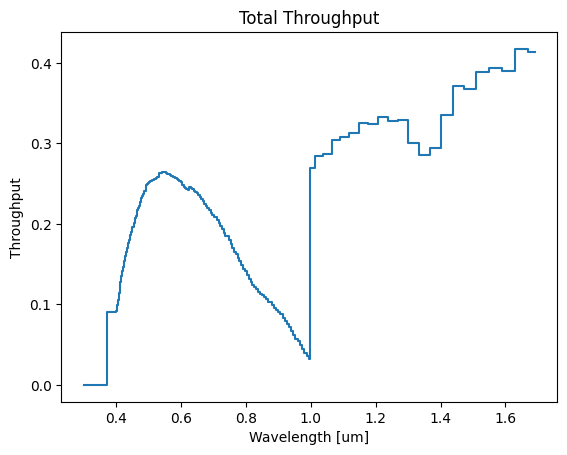

In [11]:
plt.figure()
plt.step(observation.wavelength, observatory.total_throughput, where="mid")
plt.xlabel("Wavelength [um]")
plt.ylabel("Throughput")
plt.title("Total Throughput")

Why does throughput nosedive to 1. um?
This has to do with the assumed visible QE (see below)

Initializing Coronagraph Instrument
Loading file: /obs_config/CI/CI.yaml

Optical path:
['PM', 'SM', 'TCA', 'TCA', 'TCA', 'TCA', 'wave_beamsplitter', 'pol_beamsplitter', 'FSM', 'OAPs_forward', 'OAPs_forward', 'DM1', 'DM2', 'OAPs_forward', 'Fold', 'OAPs_back', 'Apodizer', 'OAPs_back', 'Focal_Plane_Mask', 'OAPs_back', 'Lyot_Stop', 'OAPs_back', 'Field_Stop', 'OAPs_back', 'filters', 'OAPs_back', 'Detector', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless']
Calculating throughput...
Calculating instrument throughput...
--including TCA
--including TCA
--including TCA
--including TCA
--including wave_beamsplitter
--including pol_beamsplitter
--including FSM
--including OAPs_forward
--including OAPs_forward
--including DM1
-

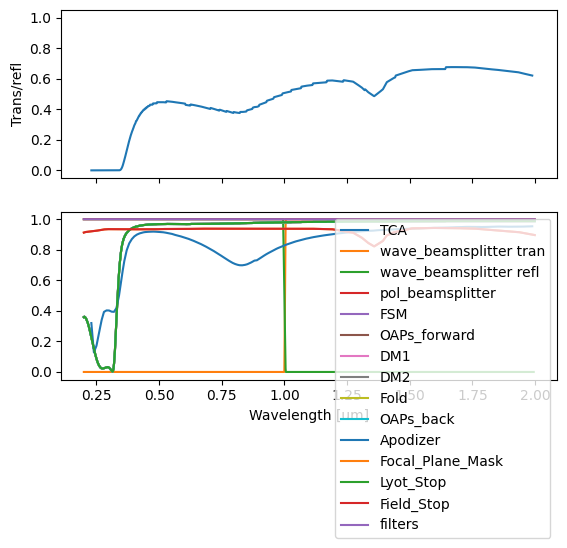

Loading IFS...


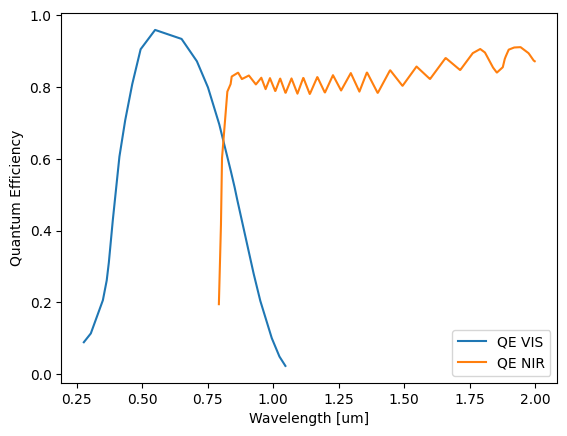

VISIBLE
-------
RN: 0.0
DC: 3e-05


NIR
---
RN: 0.4
DC: 0.0001


In [12]:
# to answer this, let's look in the YAML files for EAC1.
import eacy
eacy.load_instrument("CI", plotting=True, verbose=True) # load the coronagraph instrument given in the yaml files. This also calculates the throughput, and we can tell it to plot. 
eacy.load_detector("IFS", plotting=True, verbose=True) # load the detector instrument given in the yaml files. This also calculates the throughput, and we can tell it to plot.

Coronagraph response maps:

Text(0.5, 1.0, 'Coronagraph skytrans')

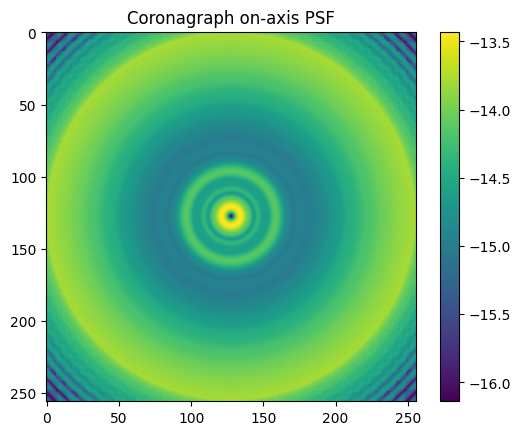

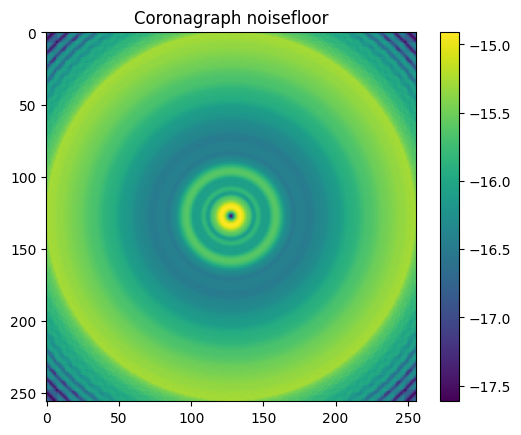

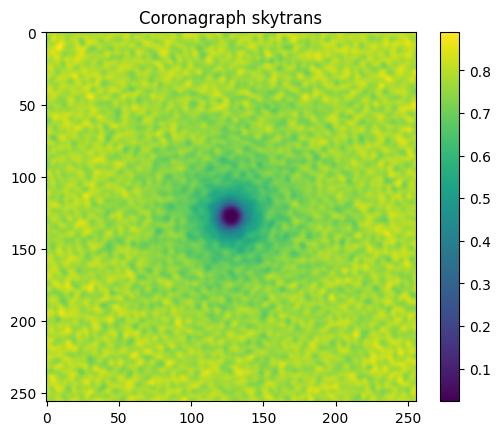

In [13]:
plt.figure()
plt.imshow(np.log10(observatory.coronagraph.Istar))
plt.colorbar()
plt.title("Coronagraph on-axis PSF")

plt.figure()
plt.imshow(np.log10(observatory.coronagraph.noisefloor))
plt.colorbar()
plt.title("Coronagraph noisefloor")

plt.figure()
plt.imshow(observatory.coronagraph.skytrans)
plt.colorbar()
plt.title("Coronagraph skytrans")



Before running the ETC, let's take a look at some of the inputs:

Text(0.5, 1.0, 'Absolute Flux of the Star')

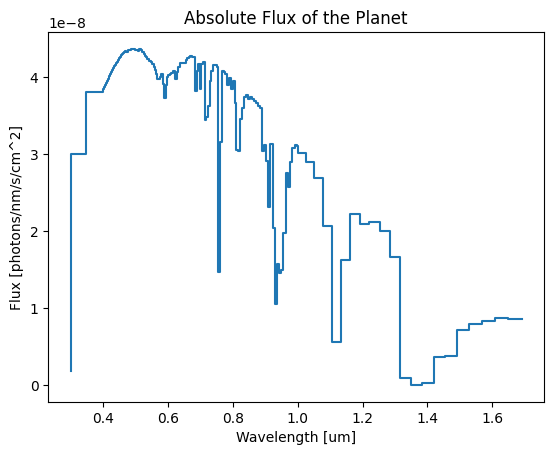

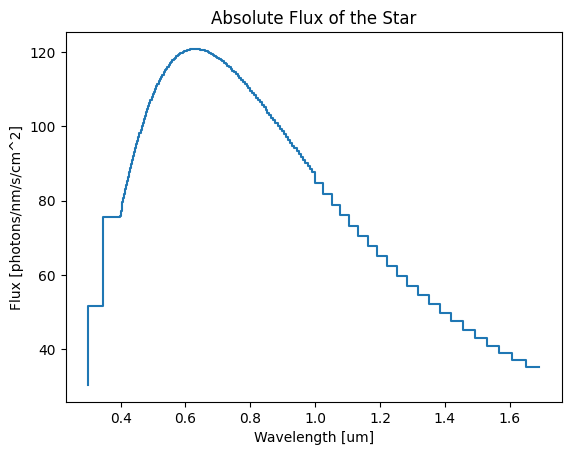

In [15]:
plt.figure()
plt.step(observation.wavelength, (getattr(scene, "Fs_over_F0")*getattr(scene, "F0")*getattr(scene, "Fp_over_Fs")))
plt.xlabel("Wavelength [um]")
plt.ylabel("Flux [photons/nm/s/cm^2]")
plt.title("Absolute Flux of the Planet")

plt.figure()
plt.step(observation.wavelength, (getattr(scene, "Fs_over_F0")*getattr(scene, "F0"))) # F0 is the zero-point and Fs_over_F0 is the ratio of the absolute flux to the zero point flux
plt.xlabel("Wavelength [um]")
plt.ylabel("Flux [photons/nm/s/cm^2]")
plt.title("Absolute Flux of the Star")


### Running the ETC
After running, the calculated exposure times will be an attribute (exptime) of the pyEDITH object. 

In [ ]:
pE.calculate_exposure_time_or_snr(observation, scene, observatory, verbose=False)

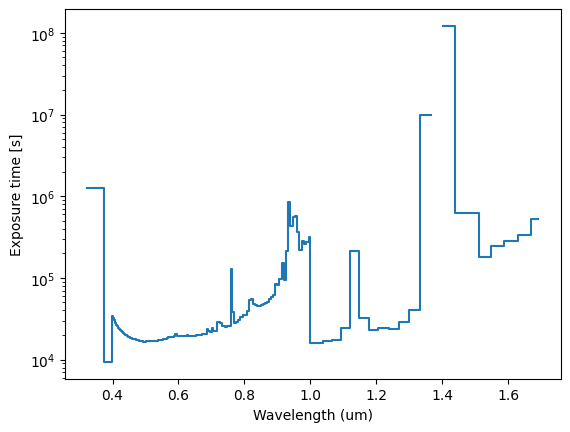

In [ ]:
# Let's plot it:
plt.figure()
plt.step(observation.wavelength, observation.exptime, where="mid")
#plt.scatter(observation.wavelength[np.isinf(observation.exptime)], np.max(observation.exptime[np.isfinite(observation.exptime)])*np.ones_like(observation.wavelength[np.isinf(observation.exptime)]), marker="X", color="red")

plt.ylabel("Exposure time [s]")
plt.xlabel("Wavelength (um)")

plt.yscale("log")


The above is for calculating the exposure time for the desired SNR in each spectral bin (we told it to calculate the exposure time to get to an SNR of 7 in each spectral bin). However, a more useful functionality for the observer is to calculate the SNR you get for each spectral bin when you give it an exposure time. Let's do something simple to demonstrate this: 

In [ ]:
# To do this, we need to specify a different parameter called "obstime":
# first let's see how long it would take to get to a 7 sigma detection at some reference lambda:
ref_lam = 0.5*u.um
ind_reflam = np.argmin(np.abs(observation.wavelength - ref_lam))
observation.obstime = observation.exptime[ind_reflam] # get the exposure time to given the results above 
pE.calculate_exposure_time_or_snr(observation, scene, observatory, mode="signal_to_noise", verbose=False)


Let's plot it:

Text(0.5, 0, 'Wavelength (um)')

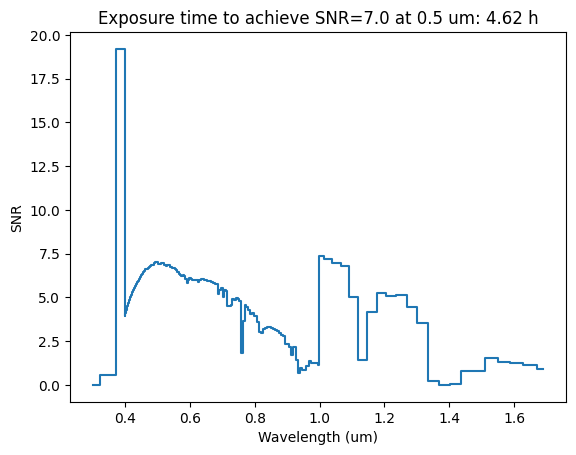

In [ ]:
plt.figure()
plt.step(observation.wavelength, observation.fullsnr, where="mid")
plt.title(f"Exposure time to achieve SNR={parameters['snr'][0]} at {ref_lam}: {observation.obstime.to(u.hr).round(2)}")

plt.ylabel("SNR")
plt.xlabel("Wavelength (um)")

Now let's say you want to calculate different exposure times for the different spectral channels you may have specified at the beginning of this tutorial. For now, there is not a way to do this internally in the ETC, but we can hack it! 


Text(0, 0.5, 'SNR')

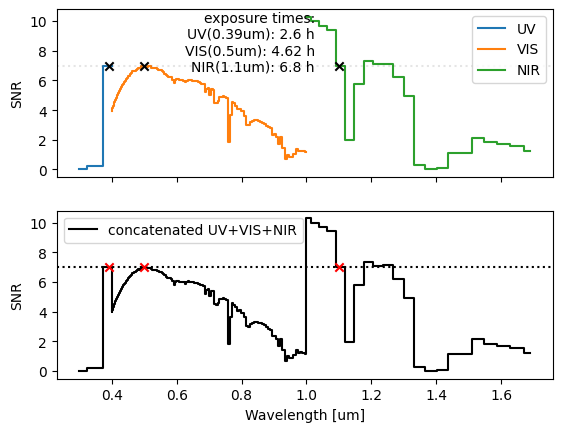

In [20]:
nchannels = len(parameters["spectral_resolution"])
# pick some reference lambdas: one for each channel. 
ref_lams = [0.39, 0.5, 1.1]

# ensure that there is one reference lambda per spectral channel
assert ref_lams[0] < parameters["lam_high"][0]
assert (ref_lams[1] >= parameters["lam_high"][0]) & (ref_lams[1] < parameters["lam_high"][1])
assert ref_lams[2] >= parameters["lam_high"][1]

# get the indeces corresponding to the spectral channels:
# remember, we are using observation.wavelength instead of parameters["wavelength"] because it is the re-gridded wavelength grid the ETC uses internally (we specified this earlier)
inds_UV = observation.wavelength.value < parameters["lam_high"][0]
inds_VIS = (observation.wavelength.value >= parameters["lam_high"][0]) & (observation.wavelength.value < parameters["lam_high"][1])
inds_NIR =  observation.wavelength.value >= parameters["lam_high"][1]

inds_arr = [inds_UV, inds_VIS, inds_NIR]

# to do this in a hacky way, we need to run the ETC three times: one for each spectral channel
snr_arrs = []
exptime_arr = []
for ref_lam in ref_lams:
    ind_reflam = np.argmin(np.abs(observation.wavelength - ref_lam*u.um))
    observation.obstime = observation.exptime[ind_reflam] # get the exposure time to given the results above 
    pE.calculate_exposure_time_or_snr(observation, scene, observatory, mode="signal_to_noise", verbose=False)
    snr_arrs.append(np.copy(observation.fullsnr))
    exptime_arr.append(np.copy(observation.exptime[ind_reflam]))

labels=["UV", "VIS", "NIR"]
fig, axes = plt.subplots(2,1, sharex=True)
snr_concat_arr = np.empty(len(observation.wavelength))

for i in range(len(ref_lams)):
    snr_arr = snr_arrs[i]
    inds = inds_arr[i]
    axes[0].step(observation.wavelength[inds], snr_arr[inds], label=labels[i], where="mid")
    #axes[0].scatter(observation.wavelength[inds][np.isinf(observation.exptime[inds])], np.max(snr_arr[inds][np.isfinite(observation.exptime[inds])])*np.ones_like(observation.wavelength[inds][np.isinf(observation.exptime[inds])]), marker="X", color="red")
    snr_concat_arr[inds] = snr_arr[inds]
axes[0].scatter(ref_lams, [7,7,7], color="k", marker="x", zorder=10)
axes[0].axhline(7, color="k", ls=":", alpha=0.1)
axes[0].legend()
axes[0].set_ylabel("SNR")
exptime_text = f"UV({ref_lams[0]}um): {exptime_arr[0].to(u.hr).round(2)}\nVIS({ref_lams[1]}um): {exptime_arr[1].to(u.hr).round(2)}\nNIR({ref_lams[2]}um): {exptime_arr[2].to(u.hr).round(2)}"
axes[0].text(0.52, 0.99, f"exposure times:\n{exptime_text}",  transform=axes[0].transAxes, ha='right', va='top')
axes[1].step(observation.wavelength, snr_concat_arr, color="k", label="concatenated UV+VIS+NIR", where="mid")
axes[1].scatter(ref_lams, [7,7,7], color="red", marker="x", zorder=10)
axes[1].axhline(7, color="k", ls=":")
axes[1].set_xlabel("Wavelength [um]")
axes[1].legend()
axes[1].set_ylabel("SNR")

Next, let's make some fake data using the SNR information we calculated. 

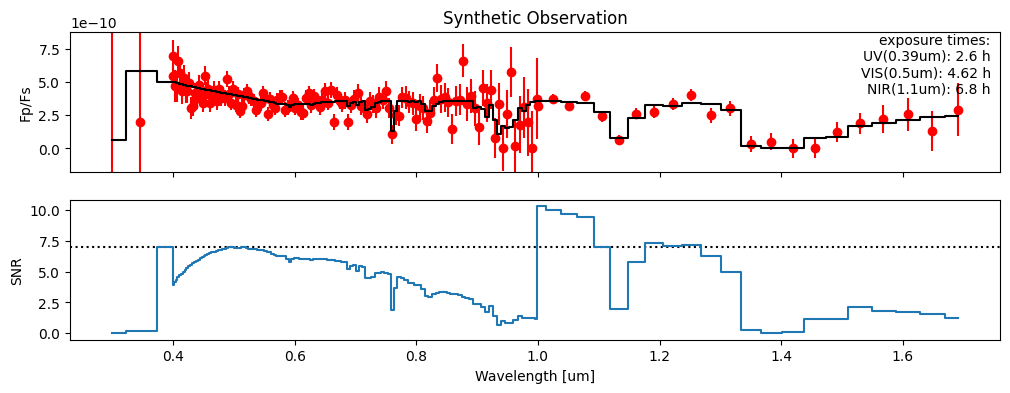

In [21]:
obs, noise = pE.utils.synthesize_observation(snr_concat_arr,
                                             exptime_arr,
                                             ref_lams,
                                             observation,
                                             scene, 
                                             random_seed=42, # seed defaults to None
                                             set_below_zero=0., # if the fake data falls below zero, set the data point as this. default = NaN
                                             )

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
axes[0].step(observation.wavelength, scene.Fp_over_Fs, color="k", where="mid", zorder=10)
axes[0].errorbar(observation.wavelength, obs, yerr=noise, fmt="o", color="red")
axes[0].set_ylabel("Fp/Fs")

axes[0].set_title("Synthetic Observation")
exptime_text = f"UV({ref_lams[0]}um): {exptime_arr[0].to(u.hr).round(2)}\nVIS({ref_lams[1]}um): {exptime_arr[1].to(u.hr).round(2)}\nNIR({ref_lams[2]}um): {exptime_arr[2].to(u.hr).round(2)}"
axes[0].text(0.99, 0.99, f"exposure times:\n{exptime_text}", transform=axes[0].transAxes, ha="right", va="top")
axes[0].set_ylim(np.median(scene.Fp_over_Fs) - 1.5 * np.median(scene.Fp_over_Fs), np.median(scene.Fp_over_Fs) + 1.5 * np.median(scene.Fp_over_Fs))
axes[1].step(observation.wavelength, snr_concat_arr, where="mid", zorder=10)
axes[1].set_xlabel("Wavelength [um]")
axes[1].set_ylabel("SNR")
axes[1].axhline(7, color="k", ls=":")


We can also plot the individual photon counts to see if we're getting something reasonable.

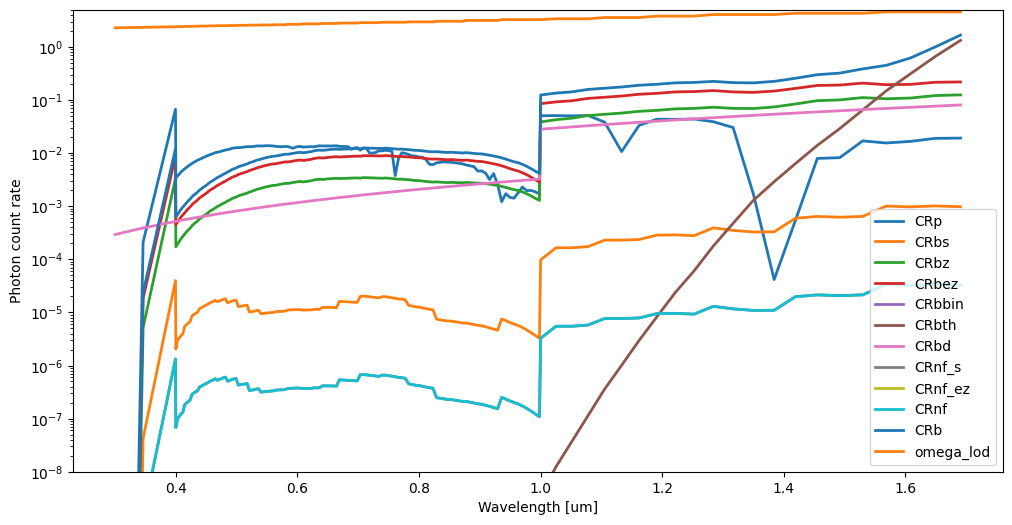

In [22]:
photon_counts = pickle.load(open("./photon_counts.pk", "rb"))
plt.figure(figsize=(12,6))
for key in photon_counts.keys():
    #print(key)
    #print(photon_counts[key])
    if key != "PPF_ez":
        plt.plot(observation.wavelength, photon_counts[key], label=key, lw=2)
plt.yscale("log")
plt.ylim(1e-8, 5e0)
plt.ylabel("Photon count rate")
plt.xlabel("Wavelength [um]")
plt.legend()

**Why does the exposure time look blocky?**

This has to do with the on-axis coronagraph response map (Istar). The planet is at a fixed separation in arcsec space, but the location is not fixed in lambda/D space. The planet appears to move closer to the star in lambd/D space with increasing wavelength, thus it experiences a different coronagraphic response. Since the on-axis PSF map is sampled at 0.25 lod, this limits our resolution for the contrast as a function of planet separation. 

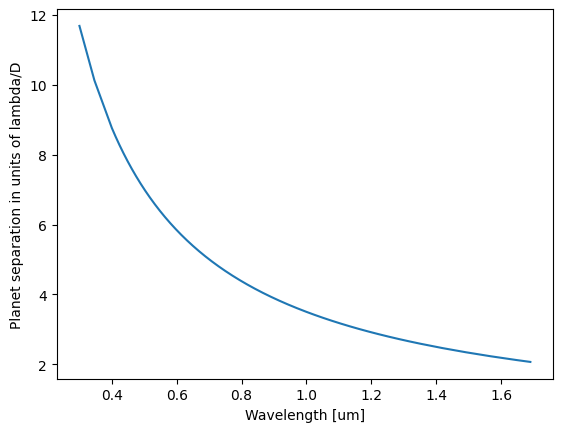

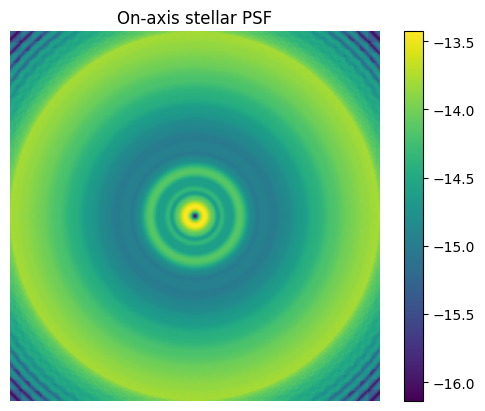

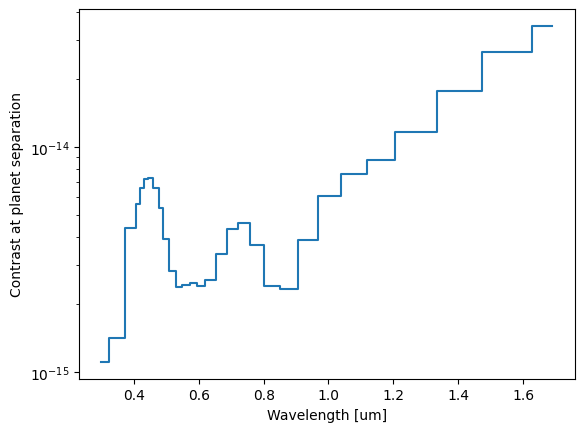

In [23]:
planet_separation_arcsec = scene.separation
planet_separation_rad = planet_separation_arcsec.to(u.rad)
tel_diam = observatory.telescope.diameter

wavelengths = observation.wavelength
planet_separation_lod = (planet_separation_rad.value * tel_diam) / wavelengths.to(u.m) 
plt.figure()
plt.plot(wavelengths, planet_separation_lod)
plt.xlabel("Wavelength [um]")
plt.ylabel("Planet separation in units of lambda/D")

# Let's revisit the on-axis stellar PSF map
plt.figure()
plt.imshow(np.log10(observatory.coronagraph.Istar))
plt.colorbar()
plt.title("On-axis stellar PSF")
plt.gca().axis("off")


# Now let's plot the coronagraphic response as a function of planetary separation
cgcenter = (observatory.coronagraph.npix - 1) / 2
cg_pixscale = 0.25 # lod units

planetary_separation_pix = planet_separation_lod/cg_pixscale + cgcenter

contrast_at_planet_sep = []
for sep in planetary_separation_pix:
    sepx = int(np.floor(sep))
    sepy = int(np.floor(cgcenter))
    contrast_at_planet_sep.append(observatory.coronagraph.Istar[sepy, sepx])

plt.figure()
plt.step(wavelengths, contrast_at_planet_sep, where="mid")
plt.xlabel("Wavelength [um]")
plt.ylabel("Contrast at planet separation")
plt.yscale("log")



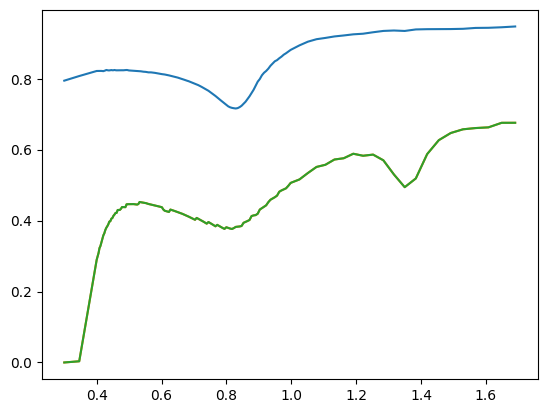

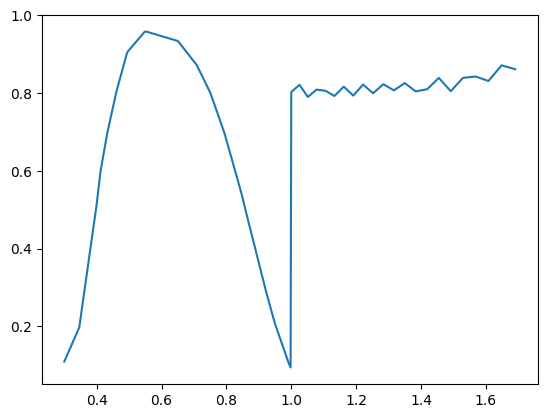

In [26]:
plt.plot(observation.wavelength,observatory.telescope.telescope_optical_throughput)
plt.plot(observation.wavelength,observatory.coronagraph.coronagraph_optical_throughput)
plt.plot(observation.wavelength,observatory.coronagraph.coronagraph_optical_throughput)
plt.figure()
plt.plot(observation.wavelength,observatory.detector.QE)

